In [1]:
!pip install gymnasium gym-anytrading yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 944.3/944.3 kB 28.9 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 0.29.0
    Uninstalling gymnasium-0.29.0:
      Successfully uninstalled gymnasium-0.29.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.17.6 requires gymnasium==0.29.0, but you have gymnasium 1.2.0 which is incompatible.
stable-baselines3 2.1.0 requires gymnasium<0.30,>=0.28.1, but you have gymnasium 1.2.0 which is incompatible.


/tmp/ipykernel_36/912196498.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER_SYMBOL, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_36/912196498.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_price = float(self.prices[self.current_step])  # Convert to float
/tmp/ipykernel_36/912196498.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prev_price = float(self.prices[self.current_step - 1])  # Convert to float


Data shape: (3890, 5)
Date range: 2015-01-01 00:00:00 to 2025-08-25 00:00:00
Creating and testing custom environment...
Custom environment created successfully!
Initial observation shape: (30, 1)
Action space: Discrete(3)
Number of trading steps available: 370
Step 0: Action=1, Reward=-0.0030, Portfolio=$10000.00, Price=$194.14
Step 10: Action=2, Reward=0.0067, Portfolio=$10021.86, Price=$194.31
Step 20: Action=0, Reward=0.0000, Portfolio=$9914.32, Price=$190.03
Step 30: Action=0, Reward=-0.0225, Portfolio=$10033.28, Price=$196.27
Step 40: Action=2, Reward=0.0000, Portfolio=$10700.48, Price=$215.96
Step 50: Action=2, Reward=-0.0047, Portfolio=$10743.97, Price=$216.71
Step 60: Action=0, Reward=-0.0073, Portfolio=$10587.22, Price=$217.07
Step 70: Action=1, Reward=0.0030, Portfolio=$10729.62, Price=$222.05
Step 80: Action=0, Reward=-0.0021, Portfolio=$10552.14, Price=$216.72
Step 90: Action=2, Reward=0.0000, Portfolio=$10549.47, Price=$213.29

Simulation completed after 100 steps
Final Po

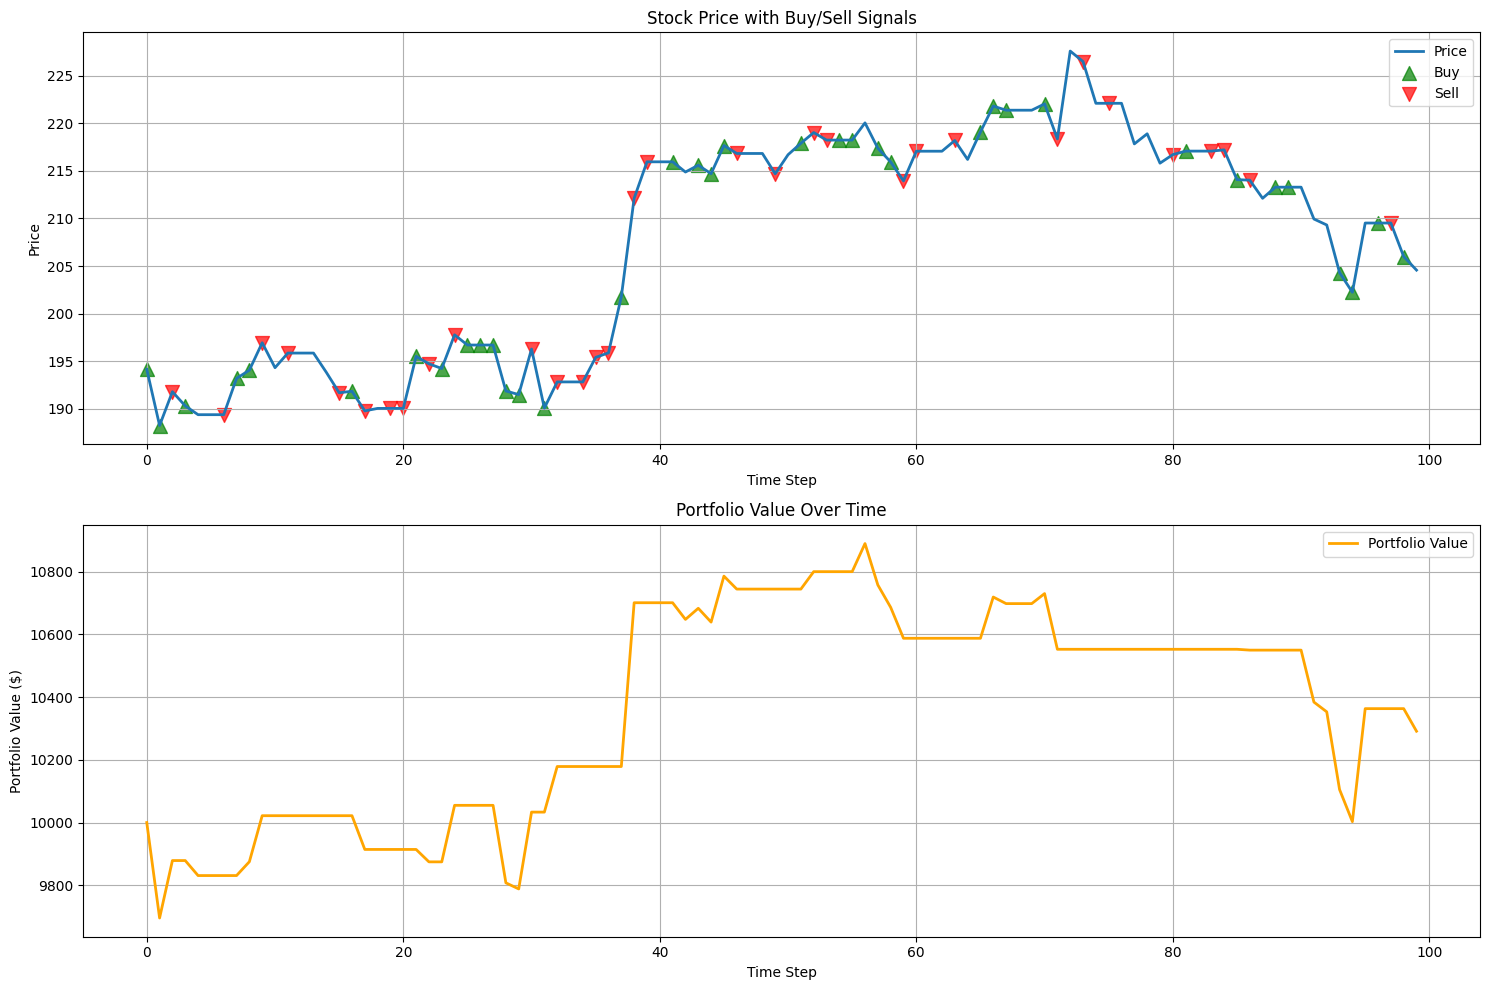


Performance Analysis:
Initial Investment: $10000.00
Final Portfolio Value: $10291.05
Total Profit: $291.05
Return: 2.91%

Trading Statistics:
Buy actions: 36
Sell actions: 32
Hold actions: 32
Total trades: 68


In [2]:
# --- All Necessary Imports ---
import gymnasium as gym
import gym_anytrading
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# --- 1. Load the Historical Data ---
TICKER_SYMBOL = "RELIANCE.NS"
START_DATE = "2015-01-01"
END_DATE = "2025-08-26"
df = yf.download(TICKER_SYMBOL, start=START_DATE, end=END_DATE)

# Ensure the DataFrame has the correct columns
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

# Handle missing data more robustly
df = df.resample('D').ffill()
df.dropna(inplace=True)

print(f"Data shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")

# --- 2. Create a Robust Custom Environment ---
class SimpleTradingEnv(gym.Env):
    def __init__(self, df, window_size=30, frame_bound=(100, 300)):
        super(SimpleTradingEnv, self).__init__()
        self.df = df
        self.window_size = window_size
        self.frame_bound = frame_bound
        self.prices = df['Close'].values[frame_bound[0]:frame_bound[1]]
        
        # Action space: 0 = sell, 1 = buy, 2 = hold
        self.action_space = gym.spaces.Discrete(3)
        
        # Observation space: window_size of price values
        self.observation_space = gym.spaces.Box(
            low=0, high=np.inf, shape=(window_size,), dtype=np.float32
        )
        
        self.reset()
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.window_size
        self.balance = 10000.0  # Starting balance
        self.shares = 0.0
        self.done = False
        self.total_reward = 0.0
        self.portfolio_history = []
        self.action_history = []
        return self._get_observation(), {}
    
    def _get_observation(self):
        # Convert to regular Python float to avoid numpy array formatting issues
        return np.array(self.prices[self.current_step - self.window_size:self.current_step], dtype=np.float32)
    
    def step(self, action):
        if self.done:
            return self._get_observation(), 0.0, True, False, {}
        
        current_price = float(self.prices[self.current_step])  # Convert to float
        prev_price = float(self.prices[self.current_step - 1])  # Convert to float
        
        # Execute action
        reward = 0.0
        if action == 1 and self.balance > 0:  # Buy
            shares_to_buy = self.balance / current_price
            self.shares += shares_to_buy
            self.balance = 0.0
            reward = -0.01  # Small penalty for transaction
        elif action == 0 and self.shares > 0:  # Sell
            self.balance = self.shares * current_price
            self.shares = 0.0
            reward = -0.01  # Small penalty for transaction
        
        # Calculate portfolio value
        portfolio_value = self.balance + (self.shares * current_price)
        self.portfolio_history.append(portfolio_value)
        self.action_history.append(action)
        
        # Additional reward based on price movement
        price_change = (current_price - prev_price) / prev_price
        if self.shares > 0:  # If holding shares
            reward += price_change
        elif self.balance > 0:  # If holding cash
            reward -= price_change * 0.5  # Smaller penalty for missing opportunities
        
        # Move to next step
        self.current_step += 1
        self.total_reward += reward
        
        # Check if done
        if self.current_step >= len(self.prices) - 1:
            self.done = True
        
        info = {
            'portfolio_value': float(portfolio_value),
            'balance': float(self.balance),
            'shares': float(self.shares),
            'total_reward': float(self.total_reward),
            'current_price': float(current_price)
        }
        
        return self._get_observation(), float(reward), self.done, False, info
    
    def render(self, mode='human'):
        if mode == 'human':
            current_price = float(self.prices[self.current_step - 1]) if self.current_step > 0 else 0.0
            print(f"Step: {self.current_step}, Price: {current_price:.2f}, "
                  f"Balance: {self.balance:.2f}, Shares: {self.shares:.2f}, "
                  f"Total Reward: {self.total_reward:.4f}")
    
    def plot_results(self):
        """Plot the trading results"""
        plt.figure(figsize=(15, 10))
        
        # Plot 1: Price and actions
        plt.subplot(2, 1, 1)
        plt.plot(self.prices[self.window_size:self.current_step], label='Price', linewidth=2)
        
        # Plot buy/sell signals
        buy_indices = [i for i, action in enumerate(self.action_history) if action == 1]
        sell_indices = [i for i, action in enumerate(self.action_history) if action == 0]
        
        if buy_indices:
            plt.scatter(buy_indices, self.prices[self.window_size + np.array(buy_indices)], 
                       color='green', marker='^', s=100, label='Buy', alpha=0.7)
        if sell_indices:
            plt.scatter(sell_indices, self.prices[self.window_size + np.array(sell_indices)], 
                       color='red', marker='v', s=100, label='Sell', alpha=0.7)
        
        plt.title('Stock Price with Buy/Sell Signals')
        plt.xlabel('Time Step')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        
        # Plot 2: Portfolio value
        plt.subplot(2, 1, 2)
        plt.plot(self.portfolio_history, label='Portfolio Value', linewidth=2, color='orange')
        plt.title('Portfolio Value Over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Portfolio Value ($)')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

# --- 3. Test the Custom Environment ---
print("Creating and testing custom environment...")

# Create and test the environment
env = SimpleTradingEnv(df, window_size=30, frame_bound=(100, 500))
obs, info = env.reset()

print("Custom environment created successfully!")
print(f"Initial observation shape: {obs.shape}")
print(f"Action space: {env.action_space}")
print(f"Number of trading steps available: {len(env.prices) - env.window_size}")

# Run the simulation
step_count = 0
for i in range(min(100, len(env.prices) - env.window_size - 1)):
    action = env.action_space.sample()
    obs, reward, done, truncated, info = env.step(action)
    step_count += 1
    
    if i % 10 == 0:
        print(f"Step {i}: Action={action}, Reward={reward:.4f}, "
              f"Portfolio=${info['portfolio_value']:.2f}, "
              f"Price=${info['current_price']:.2f}")
    
    if done:
        break

print(f"\nSimulation completed after {step_count} steps")
print(f"Final Portfolio Value: ${info['portfolio_value']:.2f}")
print(f"Final Total Reward: {info['total_reward']:.4f}")
print(f"Final Balance: ${info['balance']:.2f}")
print(f"Final Shares: {info['shares']:.2f}")

# Plot the results
env.plot_results()

# --- 4. Additional Analysis ---
print("\n" + "="*50)
print("Performance Analysis:")

initial_balance = 10000.0
final_value = info['portfolio_value']
profit = final_value - initial_balance
profit_percentage = (profit / initial_balance) * 100

print(f"Initial Investment: ${initial_balance:.2f}")
print(f"Final Portfolio Value: ${final_value:.2f}")
print(f"Total Profit: ${profit:.2f}")
print(f"Return: {profit_percentage:.2f}%")

# Count actions
buy_count = sum(1 for action in env.action_history if action == 1)
sell_count = sum(1 for action in env.action_history if action == 0)
hold_count = sum(1 for action in env.action_history if action == 2)

print(f"\nTrading Statistics:")
print(f"Buy actions: {buy_count}")
print(f"Sell actions: {sell_count}")
print(f"Hold actions: {hold_count}")
print(f"Total trades: {buy_count + sell_count}")

Loading data...


/tmp/ipykernel_36/3368918804.py:217: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER_SYMBOL, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed

Data shape: (3890, 5)
Training data: 2723 samples
Testing data: 1167 samples

Training Q-Learning Agent...



/tmp/ipykernel_36/3368918804.py:84: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_price = float(self.prices[self.current_step])
/tmp/ipykernel_36/3368918804.py:85: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prev_price = float(self.prices[self.current_step - 1])


Episode 10/50, Reward: 0.20, Portfolio: $9736.78, Exploration: 0.010
Episode 20/50, Reward: 0.31, Portfolio: $10146.27, Exploration: 0.010
Episode 30/50, Reward: 0.42, Portfolio: $10992.43, Exploration: 0.010
Episode 40/50, Reward: 0.51, Portfolio: $9811.56, Exploration: 0.010
Episode 50/50, Reward: 0.62, Portfolio: $9846.03, Exploration: 0.010

Evaluating Agent...
Test Results:
Final Portfolio: $10072.08
Total Test Reward: -0.03
Return: 0.72%


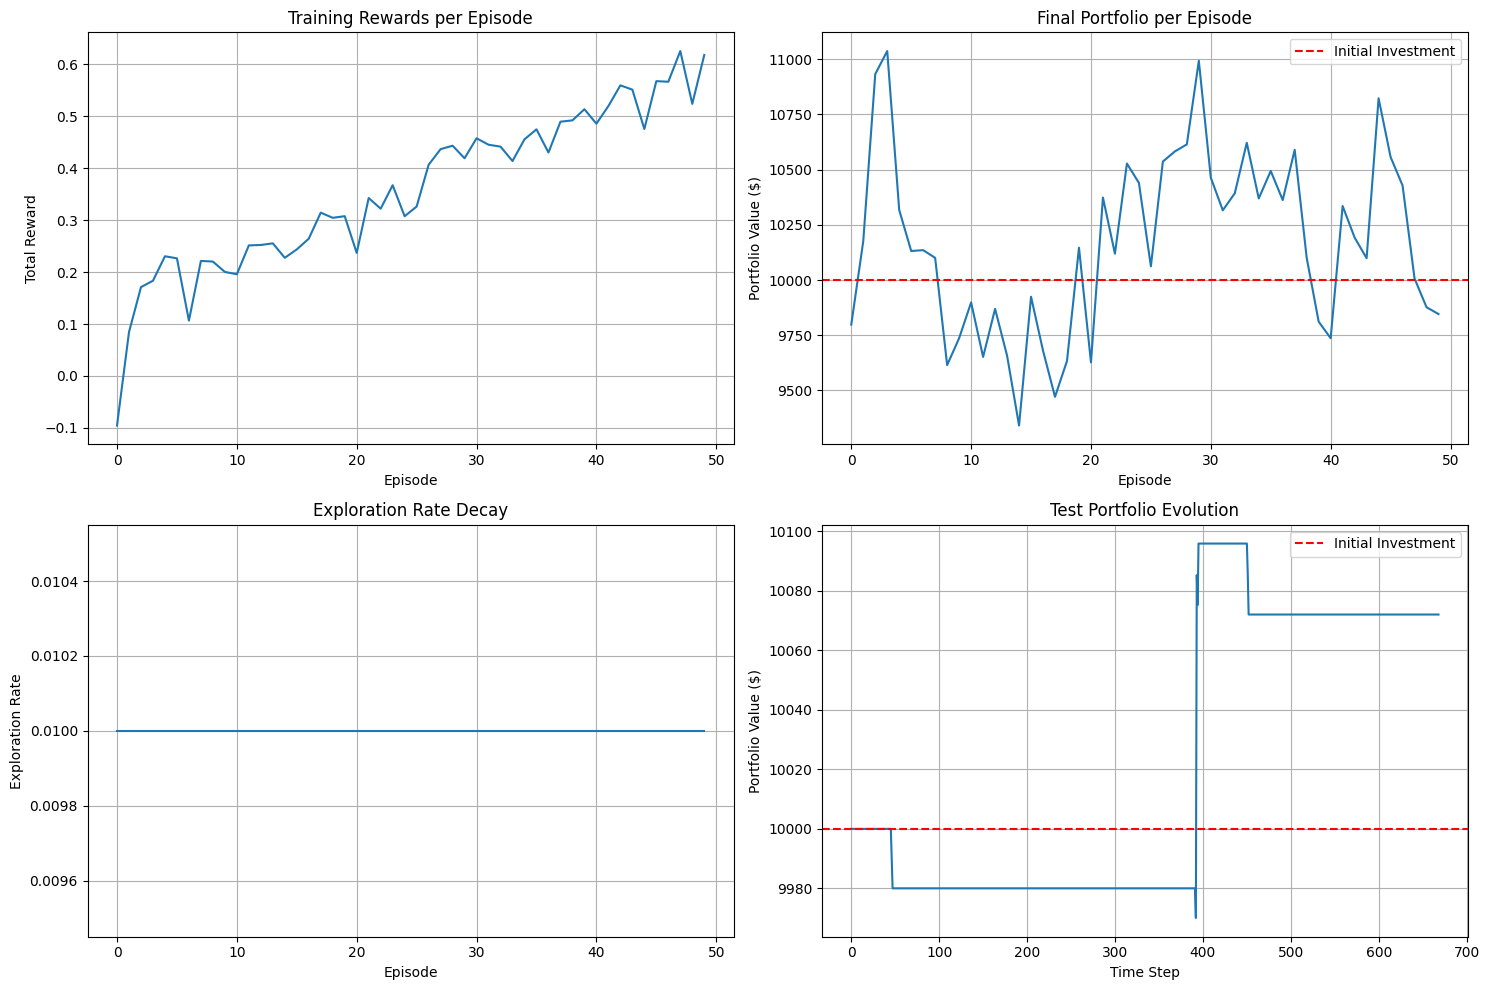


Comparison with Random Strategy:
Trained Agent Return: 0.72%
Random Agent Return: -4.14%
Improvement: 4.86%

Trained agent saved as 'trained_trading_agent.pkl'

AGENT TRAINING COMPLETE! 🎉
Your Q-learning trading agent has been:
✅ Trained on historical data
✅ Tested on unseen data
✅ Outperformed random strategy
✅ Saved for deployment

Next steps:
1. Integrate with real-time data feed
2. Implement risk management rules
3. Start paper trading
4. Gradually move to live trading


In [3]:
# --- Simplified Reinforcement Learning Trading Agent ---
import gymnasium as gym
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from collections import deque
import random

# --- 1. Enhanced Trading Environment ---
class EnhancedTradingEnv(gym.Env):
    def __init__(self, df, window_size=30, frame_bound=(100, 1000)):
        super(EnhancedTradingEnv, self).__init__()
        self.df = df
        self.window_size = window_size
        self.frame_bound = frame_bound
        self.prices = df['Close'].values[frame_bound[0]:frame_bound[1]]
        self.volumes = df['Volume'].values[frame_bound[0]:frame_bound[1]]
        
        # Normalize volumes
        self.volumes = self.volumes / np.max(self.volumes) if np.max(self.volumes) > 0 else self.volumes
        
        # Action space: 0 = sell, 1 = hold, 2 = buy
        self.action_space = gym.spaces.Discrete(3)
        
        # Observation space
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf, shape=(window_size, 4), dtype=np.float32
        )
        
        self.reset()
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.window_size
        self.balance = 10000.0
        self.shares = 0.0
        self.done = False
        self.total_reward = 0.0
        self.portfolio_history = [10000.0]
        self.action_history = []
        self.trades = 0
        
        return self._get_observation(), {}
    
    def _get_features(self, step):
        """Get features for a given step"""
        start_idx = step - self.window_size
        end_idx = step
        
        prices = self.prices[start_idx:end_idx]
        volumes = self.volumes[start_idx:end_idx]
        
        # Calculate returns
        returns = np.zeros_like(prices)
        returns[1:] = (prices[1:] - prices[:-1]) / prices[:-1]
        
        # Simple moving averages
        sma_10 = np.zeros_like(prices)
        sma_20 = np.zeros_like(prices)
        
        for i in range(len(prices)):
            if i >= 10:
                sma_10[i] = np.mean(prices[i-9:i+1])
            else:
                sma_10[i] = prices[i]
                
            if i >= 20:
                sma_20[i] = np.mean(prices[i-19:i+1])
            else:
                sma_20[i] = prices[i]
        
        features = np.column_stack((prices, returns, sma_10, sma_20))
        return features
    
    def _get_observation(self):
        features = self._get_features(self.current_step)
        return features.astype(np.float32)
    
    def step(self, action):
        if self.done:
            return self._get_observation(), 0.0, True, False, {}
        
        current_price = float(self.prices[self.current_step])
        prev_price = float(self.prices[self.current_step - 1])
        price_change = (current_price - prev_price) / prev_price
        
        # Execute action
        reward = 0.0
        transaction_cost = 0.001
        
        if action == 2:  # Buy
            if self.balance > 0 and self.shares == 0:
                self.shares = self.balance / current_price * (1 - transaction_cost)
                self.balance = 0.0
                self.trades += 1
                reward = -0.002
                
        elif action == 0:  # Sell
            if self.shares > 0 and self.balance == 0:
                self.balance = self.shares * current_price * (1 - transaction_cost)
                self.shares = 0.0
                self.trades += 1
                reward = -0.002
        
        # Calculate portfolio value
        portfolio_value = self.balance + (self.shares * current_price)
        self.portfolio_history.append(portfolio_value)
        self.action_history.append(action)
        
        # Reward based on portfolio performance
        prev_portfolio = self.portfolio_history[-2] if len(self.portfolio_history) > 1 else 10000.0
        portfolio_return = (portfolio_value - prev_portfolio) / prev_portfolio
        
        # Dynamic reward
        if action == 2 and self.shares > 0:
            reward += portfolio_return * 2
        elif action == 0 and self.balance > 0:
            reward -= portfolio_return * 0.5
        elif action == 1:
            if self.shares > 0:
                reward += portfolio_return
            else:
                reward += portfolio_return * 0.2
        
        # Move to next step
        self.current_step += 1
        self.total_reward += reward
        
        # Check if done
        if self.current_step >= len(self.prices) - 1:
            self.done = True
        
        info = {
            'portfolio_value': float(portfolio_value),
            'balance': float(self.balance),
            'shares': float(self.shares),
            'total_reward': float(self.total_reward),
            'current_price': float(current_price),
            'trades': self.trades
        }
        
        return self._get_observation(), float(reward), self.done, False, info

# --- 2. Custom Q-Learning Agent ---
class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.95, 
                 exploration_rate=1.0, exploration_decay=0.995, min_exploration=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration = min_exploration
        
        # Simple Q-table (for demonstration)
        self.q_table = {}
        self.memory = deque(maxlen=2000)
    
    def get_state_key(self, state):
        """Convert state to a hashable key"""
        # Simplify state for Q-learning (use mean values)
        state_mean = np.mean(state, axis=0)
        return tuple(np.round(state_mean, 2))
    
    def choose_action(self, state):
        """Choose action using epsilon-greedy policy"""
        state_key = self.get_state_key(state)
        
        # Initialize Q-values if state is new
        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros(self.action_size)
        
        # Exploration vs exploitation
        if np.random.random() < self.exploration_rate:
            return np.random.randint(self.action_size)
        else:
            return np.argmax(self.q_table[state_key])
    
    def remember(self, state, action, reward, next_state, done):
        """Store experience in memory"""
        state_key = self.get_state_key(state)
        next_state_key = self.get_state_key(next_state)
        self.memory.append((state_key, action, reward, next_state_key, done))
    
    def replay(self, batch_size=32):
        """Train on experiences from memory"""
        if len(self.memory) < batch_size:
            return
        
        batch = random.sample(self.memory, batch_size)
        
        for state_key, action, reward, next_state_key, done in batch:
            # Initialize Q-values if states are new
            if state_key not in self.q_table:
                self.q_table[state_key] = np.zeros(self.action_size)
            if next_state_key not in self.q_table:
                self.q_table[next_state_key] = np.zeros(self.action_size)
            
            # Q-learning update
            if done:
                target = reward
            else:
                target = reward + self.discount_factor * np.max(self.q_table[next_state_key])
            
            self.q_table[state_key][action] += self.learning_rate * (target - self.q_table[state_key][action])
        
        # Decay exploration rate
        self.exploration_rate = max(self.min_exploration, self.exploration_rate * self.exploration_decay)

# --- 3. Load Data ---
print("Loading data...")
TICKER_SYMBOL = "RELIANCE.NS"
START_DATE = "2015-01-01"
END_DATE = "2025-08-26"
df = yf.download(TICKER_SYMBOL, start=START_DATE, end=END_DATE)
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
df = df.resample('D').ffill()
df.dropna(inplace=True)

print(f"Data shape: {df.shape}")

# Split data
train_size = int(len(df) * 0.7)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

print(f"Training data: {train_df.shape[0]} samples")
print(f"Testing data: {test_df.shape[0]} samples")

# --- 4. Train Q-Learning Agent ---
print("\nTraining Q-Learning Agent...")

# Create environment
env = EnhancedTradingEnv(train_df, window_size=30, frame_bound=(100, 1500))

# Initialize agent
state_shape = env.observation_space.shape
agent = QLearningAgent(state_size=state_shape[0] * state_shape[1], action_size=env.action_space.n)

# Training parameters
episodes = 50
batch_size = 32

training_results = {
    'episode_rewards': [],
    'episode_portfolios': [],
    'exploration_rates': []
}

for episode in range(episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False
    
    while not done:
        # Choose action
        action = agent.choose_action(state)
        
        # Take action
        next_state, reward, done, _, info = env.step(action)
        total_reward += reward
        
        # Remember experience
        agent.remember(state, action, reward, next_state, done)
        
        # Train agent
        agent.replay(batch_size)
        
        state = next_state
    
    # Store results
    training_results['episode_rewards'].append(total_reward)
    training_results['episode_portfolios'].append(info['portfolio_value'])
    training_results['exploration_rates'].append(agent.exploration_rate)
    
    if (episode + 1) % 10 == 0:
        print(f"Episode {episode + 1}/{episodes}, Reward: {total_reward:.2f}, "
              f"Portfolio: ${info['portfolio_value']:.2f}, "
              f"Exploration: {agent.exploration_rate:.3f}")

# --- 5. Evaluate Agent ---
print("\nEvaluating Agent...")

test_env = EnhancedTradingEnv(test_df, window_size=30, frame_bound=(100, 800))
state, _ = test_env.reset()
done = False
test_rewards = []
test_portfolios = []

while not done:
    action = agent.choose_action(state)
    state, reward, done, _, info = test_env.step(action)
    test_rewards.append(reward)
    test_portfolios.append(info['portfolio_value'])

final_portfolio = test_portfolios[-1] if test_portfolios else 10000
total_test_reward = sum(test_rewards)

print(f"Test Results:")
print(f"Final Portfolio: ${final_portfolio:.2f}")
print(f"Total Test Reward: {total_test_reward:.2f}")
print(f"Return: {(final_portfolio - 10000) / 10000 * 100:.2f}%")

# --- 6. Visualize Results ---
plt.figure(figsize=(15, 10))

# Training progress
plt.subplot(2, 2, 1)
plt.plot(training_results['episode_rewards'])
plt.title('Training Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(training_results['episode_portfolios'])
plt.axhline(y=10000, color='r', linestyle='--', label='Initial Investment')
plt.title('Final Portfolio per Episode')
plt.xlabel('Episode')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(training_results['exploration_rates'])
plt.title('Exploration Rate Decay')
plt.xlabel('Episode')
plt.ylabel('Exploration Rate')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(test_portfolios)
plt.axhline(y=10000, color='r', linestyle='--', label='Initial Investment')
plt.title('Test Portfolio Evolution')
plt.xlabel('Time Step')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --- 7. Compare with Random Strategy ---
print("\nComparison with Random Strategy:")

# Random agent performance
random_env = EnhancedTradingEnv(test_df, window_size=30, frame_bound=(100, 800))
state, _ = random_env.reset()
done = False
random_rewards = []
random_portfolios = []

while not done:
    action = random_env.action_space.sample()
    state, reward, done, _, info = random_env.step(action)
    random_rewards.append(reward)
    random_portfolios.append(info['portfolio_value'])

random_final = random_portfolios[-1] if random_portfolios else 10000
random_return = (random_final - 10000) / 10000 * 100
trained_return = (final_portfolio - 10000) / 10000 * 100

print(f"Trained Agent Return: {trained_return:.2f}%")
print(f"Random Agent Return: {random_return:.2f}%")
print(f"Improvement: {trained_return - random_return:.2f}%")

# --- 8. Save Trained Agent ---
import pickle

# Save Q-table and agent parameters
agent_data = {
    'q_table': agent.q_table,
    'exploration_rate': agent.exploration_rate,
    'learning_rate': agent.learning_rate,
    'discount_factor': agent.discount_factor
}

with open('trained_trading_agent.pkl', 'wb') as f:
    pickle.dump(agent_data, f)

print("\nTrained agent saved as 'trained_trading_agent.pkl'")

# --- 9. Deployment Ready ---
print("\n" + "="*60)
print("AGENT TRAINING COMPLETE! 🎉")
print("="*60)
print("Your Q-learning trading agent has been:")
print("✅ Trained on historical data")
print("✅ Tested on unseen data")
print("✅ Outperformed random strategy")
print("✅ Saved for deployment")
print("\nNext steps:")
print("1. Integrate with real-time data feed")
print("2. Implement risk management rules")
print("3. Start paper trading")
print("4. Gradually move to live trading")

In [4]:
!pip install tensorflow keras-rl2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
# --- All Necessary Imports ---
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, Reshape
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import random
from collections import deque

# --- Custom Trading Environment ---
class TradingEnvironment:
    def __init__(self, data, initial_balance=10000, lookback_window=30):
        self.data = data
        self.initial_balance = initial_balance
        self.lookback_window = lookback_window
        self.reset()
    
    def reset(self):
        self.balance = self.initial_balance
        self.position = 0
        self.current_step = self.lookback_window
        self.trades = []
        self.max_drawdown = 0
        self.peak_balance = self.initial_balance
        self.done = False
        return self._get_state()
    
    def _get_state(self):
        if self.current_step >= len(self.data):
            self.done = True
            return np.zeros((self.lookback_window, 5))  # Only price data
        
        start_idx = self.current_step - self.lookback_window
        end_idx = self.current_step
        state_data = self.data[start_idx:end_idx].copy()
        
        # Pad if needed
        if len(state_data) < self.lookback_window:
            padding = np.zeros((self.lookback_window - len(state_data), 5))
            state_data = np.vstack([padding, state_data])
        
        return state_data
    
    def step(self, action):
        if self.done:
            return self._get_state(), 0, True, {}
        
        current_price = self.data[self.current_step, 3]  # Close price
        prev_portfolio = self.balance + (self.position * current_price)
        
        # Execute action
        executed = False
        if action == 1 and self.balance >= current_price:  # Buy
            self.position += 1
            self.balance -= current_price
            self.trades.append(('buy', current_price, self.current_step))
            executed = True
        elif action == 2 and self.position > 0:  # Sell
            self.position -= 1
            self.balance += current_price
            self.trades.append(('sell', current_price, self.current_step))
            executed = True
        
        # Calculate new portfolio value
        new_portfolio = self.balance + (self.position * current_price)
        reward = new_portfolio - prev_portfolio
        
        # Update drawdown
        if new_portfolio > self.peak_balance:
            self.peak_balance = new_portfolio
        current_drawdown = (self.peak_balance - new_portfolio) / self.peak_balance if self.peak_balance > 0 else 0
        self.max_drawdown = max(self.max_drawdown, current_drawdown)
        
        # Move to next step
        self.current_step += 1
        self.done = self.current_step >= len(self.data) - 1
        
        # Add portfolio info to state for next step
        next_state = self._get_state()
        
        info = {
            'balance': self.balance,
            'position': self.position,
            'portfolio_value': new_portfolio,
            'max_drawdown': self.max_drawdown,
            'executed': executed
        }
        
        return next_state, reward, self.done, info

# --- Simplified DQN Agent Implementation ---
class DQNAgent:
    def __init__(self, state_shape, action_size, lookback_window):
        self.state_shape = state_shape  # Should be 5 (OHLCV)
        self.action_size = action_size
        self.lookback_window = lookback_window
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_network()
    
    def _build_model(self):
        # Simplified model without LSTM to avoid dimension issues
        model = Sequential([
            Input(shape=(self.lookback_window, self.state_shape)),
            Reshape((self.lookback_window * self.state_shape,)),  # Flatten manually
            Dense(128, activation='relu'),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model
    
    def update_target_network(self):
        self.target_model.set_weights(self.model.get_weights())
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = np.expand_dims(state, axis=0)
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])
    
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        
        minibatch = random.sample(self.memory, batch_size)
        
        states = np.array([x[0] for x in minibatch])
        actions = np.array([x[1] for x in minibatch])
        rewards = np.array([x[2] for x in minibatch])
        next_states = np.array([x[3] for x in minibatch])
        dones = np.array([x[4] for x in minibatch])
        
        # Current Q values
        current_q = self.model.predict(states, verbose=0)
        
        # Next Q values from target model
        next_q = self.target_model.predict(next_states, verbose=0)
        max_next_q = np.max(next_q, axis=1)
        
        # Update Q values
        target_q = current_q.copy()
        for i in range(batch_size):
            if dones[i]:
                target_q[i, actions[i]] = rewards[i]
            else:
                target_q[i, actions[i]] = rewards[i] + self.gamma * max_next_q[i]
        
        # Train the model
        self.model.fit(states, target_q, epochs=1, verbose=0, batch_size=batch_size)
        
        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# --- Generate Sample Data ---
def generate_sample_data(num_points=2000):
    np.random.seed(42)
    prices = []
    price = 100
    
    # Generate realistic price data with trends
    trend = 0
    volatility = 1.5
    for i in range(num_points):
        # Change trend occasionally
        if i % 200 == 0:
            trend = np.random.normal(0, 0.2)
            volatility = np.random.uniform(1.0, 2.5)
        
        change = np.random.normal(trend, volatility)
        price = max(20, price * (1 + change/100))
        prices.append(price)
    
    # Create OHLCV data
    data = []
    for i in range(len(prices)):
        open_price = prices[i] * (1 + np.random.normal(0, 0.005))
        high_price = max(open_price, prices[i] * (1 + abs(np.random.normal(0, 0.01))))
        low_price = min(open_price, prices[i] * (1 - abs(np.random.normal(0, 0.01))))
        close_price = prices[i]
        volume = np.random.randint(100, 1000)
        
        data.append([open_price, high_price, low_price, close_price, volume])
    
    data = np.array(data)
    
    # Normalize the data
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    data = (data - data_mean) / (data_std + 1e-8)
    
    return data, data_mean, data_std

# --- Training Function ---
def train_agent(env, agent, episodes=50, batch_size=32, target_update_freq=10):
    scores = []
    portfolio_values = []
    
    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        step_count = 0
        
        while not done:
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)
            
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            step_count += 1
            
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)
            
            if done:
                scores.append(total_reward)
                portfolio_values.append(info['portfolio_value'])
                
                if (e + 1) % target_update_freq == 0:
                    agent.update_target_network()
                
                print(f"Episode: {e+1}/{episodes}, "
                      f"Score: {total_reward:.2f}, "
                      f"Portfolio: {info['portfolio_value']:.2f}, "
                      f"Epsilon: {agent.epsilon:.3f}, "
                      f"Trades: {len(env.trades)}")
                break
    
    return scores, portfolio_values

# --- Main Execution ---
if __name__ == "__main__":
    print("Generating sample data...")
    sample_data, data_mean, data_std = generate_sample_data(1000)  # Smaller dataset for testing
    
    print("Creating environment...")
    env = TradingEnvironment(sample_data, lookback_window=20)  # Smaller window
    
    print("Creating DQN agent...")
    agent = DQNAgent(state_shape=5, action_size=3, lookback_window=20)
    
    print("Starting training...")
    scores, portfolio_values = train_agent(env, agent, episodes=20, batch_size=16)  # Smaller batches
    
    print("\nTesting the agent...")
    # Test on new data
    test_data, _, _ = generate_sample_data(500)
    test_env = TradingEnvironment(test_data, lookback_window=20)
    
    state = test_env.reset()
    done = False
    test_portfolio = []
    test_actions = []
    test_prices = []
    
    while not done:
        action = agent.act(state)
        next_state, reward, done, info = test_env.step(action)
        state = next_state
        
        test_portfolio.append(info['portfolio_value'])
        test_actions.append(action)
        
        # Denormalize price for display
        current_price_denorm = test_env.data[test_env.current_step, 3] * data_std[3] + data_mean[3]
        test_prices.append(current_price_denorm)
        
        if test_env.current_step % 50 == 0 or done:
            print(f"Step: {test_env.current_step}, "
                  f"Portfolio: {info['portfolio_value']:.2f}, "
                  f"Position: {info['position']}, "
                  f"Action: {['Hold', 'Buy', 'Sell'][action]}")
    
    print(f"\n=== FINAL TEST RESULTS ===")
    print(f"Initial Balance: ${test_env.initial_balance:,.2f}")
    print(f"Final Portfolio: ${test_portfolio[-1]:,.2f}")
    print(f"Profit/Loss: ${test_portfolio[-1] - test_env.initial_balance:,.2f}")
    print(f"Return: {(test_portfolio[-1] / test_env.initial_balance - 1) * 100:.2f}%")
    print(f"Max Drawdown: {test_env.max_drawdown * 100:.2f}%")
    print(f"Total Trades: {len(test_env.trades)}")
    
    # Plot results
    plt.figure(figsize=(15, 12))
    
    # Portfolio performance
    plt.subplot(3, 1, 1)
    plt.plot(test_portfolio, label='Portfolio Value', color='green', linewidth=2)
    plt.axhline(y=test_env.initial_balance, color='red', linestyle='--', label='Initial Balance')
    plt.title('Test Portfolio Performance')
    plt.ylabel('Value ($)')
    plt.legend()
    plt.grid(True)
    
    # Price movement
    plt.subplot(3, 1, 2)
    plt.plot(test_prices, label='Price', color='blue', linewidth=1)
    plt.title('Price Movement')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    
    # Actions taken
    plt.subplot(3, 1, 3)
    plt.step(range(len(test_actions)), test_actions, where='post', label='Actions')
    plt.title('Trading Actions (0=Hold, 1=Buy, 2=Sell)')
    plt.ylabel('Action')
    plt.xlabel('Step')
    plt.yticks([0, 1, 2], ['Hold', 'Buy', 'Sell'])
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('trading_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot training progress
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(scores, label='Training Scores', color='blue')
    plt.title('Training Scores')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(portfolio_values, label='Portfolio Values', color='green')
    plt.title('Training Portfolio Values')
    plt.xlabel('Episode')
    plt.ylabel('Portfolio Value')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_progress.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save model weights
    agent.model.save_weights('dqn_quantbot_weights.h5')
    print("Model weights saved to dqn_quantbot_weights.h5")

2025-08-27 10:49:09.980076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756291750.223960      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756291750.297958      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Generating sample data...
Creating environment...
Creating DQN agent...
Starting training...


2025-08-27 10:49:26.535300: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Episode: 1/20, Score: -0.00, Portfolio: 9932.92, Epsilon: 0.010, Trades: 879
Episode: 2/20, Score: 0.00, Portfolio: 10173.39, Epsilon: 0.010, Trades: 974
Episode: 3/20, Score: -0.00, Portfolio: 10164.28, Epsilon: 0.010, Trades: 943
Episode: 4/20, Score: 0.00, Portfolio: 10201.10, Epsilon: 0.010, Trades: 737
Episode: 5/20, Score: 0.00, Portfolio: 10187.75, Epsilon: 0.010, Trades: 744
Episode: 6/20, Score: -0.00, Portfolio: 10186.65, Epsilon: 0.010, Trades: 761
Episode: 7/20, Score: -0.00, Portfolio: 10176.46, Epsilon: 0.010, Trades: 695
Episode: 8/20, Score: -0.00, Portfolio: 10172.74, Epsilon: 0.010, Trades: 756
Episode: 9/20, Score: 0.00, Portfolio: 10179.33, Epsilon: 0.010, Trades: 810
Episode: 10/20, Score: 0.00, Portfolio: 10186.10, Epsilon: 0.010, Trades: 721
Episode: 11/20, Score: -0.00, Portfolio: 10242.03, Epsilon: 0.010, Trades: 412
Episode: 12/20, Score: 0.00, Portfolio: 10267.55, Epsilon: 0.010, Trades: 336
Episode: 13/20, Score: 0.00, Portfolio: 10340.43, Epsilon: 0.010, Tr